In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['lines.linewidth'] = 2

import pvpltools
from pvpltools import iec61853

from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

print(pvpltools.module_efficiency.__doc__)



This module contains implementations of several PV module efficiency models.

These models have a common purpose, which is to predict the efficiency at
maximum power point as a function of the main operating conditions:
effective irradiance and module temperature.

A function to fit any of these models to measurements is also provided.

Copyright (c) 2019-2020 Anton Driesse, PV Performance Labs.



Now get some efficiency measurements to work with. A file containing 
module matrix measurements can be downloaded from
the PVPMC website at https://pvpmc.sandia.gov/download/7701/.

In [2]:
# this is the name of the downloaded file (unless you renamed it)
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'

# The first sheet is for the Panasonic HIT module
TYPE = 'Panasonic HIT'

matrix = pd.read_excel('data/' + measurements_file, sheet_name=0,
                       usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']

# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values

# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

matrix

,irradiance,temperature,eta
0,100,15,0.935730
1,200,15,0.978227
2,400,15,1.007194
3,600,15,1.022552
4,800,15,1.027077
5,1000,15,1.026549
6,100,25,0.907523
7,200,25,0.948437
8,400,25,0.980789
9,600,25,0.994289


In [3]:
# it really is matrix data
# this becomes more obvious when you pivot it

grid = matrix.pivot(*matrix.columns)

grid

temperature,15,25,50,75
irradiance,,,,
100,0.935730,0.907523,0.833199,0.746943
200,0.978227,0.948437,0.879565,0.792776
400,1.007194,0.980789,0.908011,0.826435
600,1.022552,0.994289,0.920241,0.842713
800,1.027077,0.998903,0.925466,0.847741
1000,1.026549,1.000000,0.927551,0.849045
1100,NaN,0.998982,0.926319,0.849035


In [4]:
# now fit my favorite model

popt, pcov = fit_efficiency_model(matrix.irradiance,
                            matrix.temperature,
                            matrix.eta,
                            adr,
                            )
popt


array([ 0.99879112, -5.85209314,  0.01939665,  0.0696307 ,  0.21036569])

In [5]:
# wait, it can't be that easy!

adr(600, 15, *popt)

1.0225159488531759

In [6]:
# yes it can

In [7]:
# define some ranges for plotting

ggg = np.logspace(-0.1, 3.1, 51)
tt = np.array([0, 15, 25, 50, 75, 90])

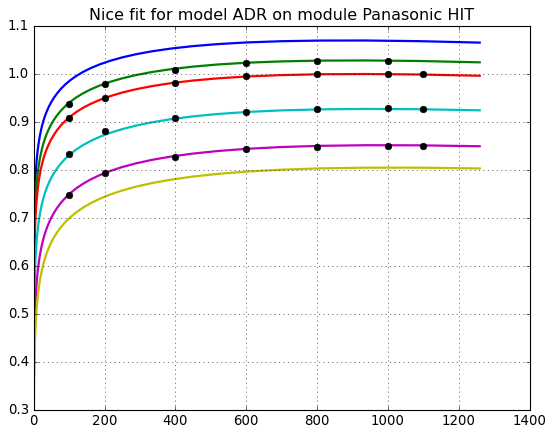

In [8]:
plt.figure()

for t in tt:
    plt.plot(ggg, adr(ggg, t, *popt))
    
plt.plot(grid, 'ko')

plt.title('Nice fit for model %s on module %s' % ('ADR', TYPE));

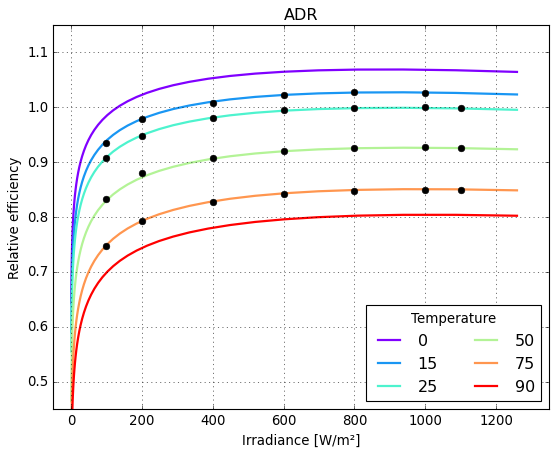

In [9]:
# gather plotting commands into a convenient function

def plot_model(model, params):

    ttt = np.linspace(-20, 80, 21)
    ggg = np.logspace(-0.1, 3.1, 51)
    gg = np.array([50, 100, 200, 400, 800, 1000, 1100])
    tt = np.array([0, 15, 25, 50, 75, 90])

    plt.figure()
    plt.gca().set_prop_cycle('color', plt.cm.rainbow(np.linspace(0,1,len(tt))))

    for t in tt:
        plt.plot(ggg, model(ggg, t, *params))

    plt.xlim(-50, 1350)
    plt.ylim(.45, 1.15)
    plt.xlabel('Irradiance [W/m²]')
    plt.ylabel('Relative efficiency')
    plt.legend(tt, title='Temperature', ncol=2, loc='best')
    plt.title(model.__name__.upper())
    return plt.gca()

ax = plot_model(adr, popt);
ax.plot(grid, 'ko');

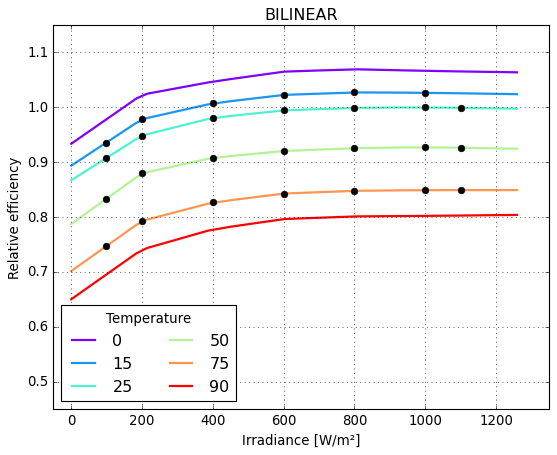

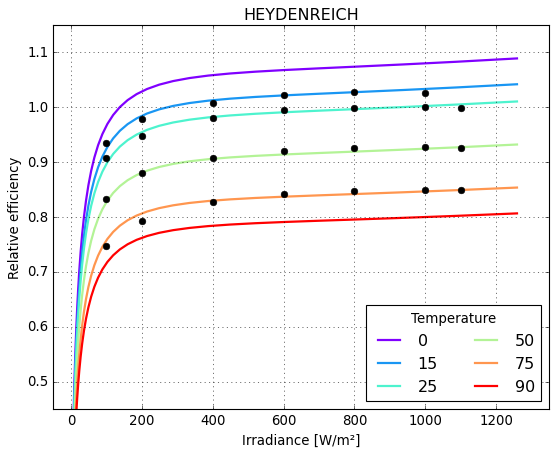

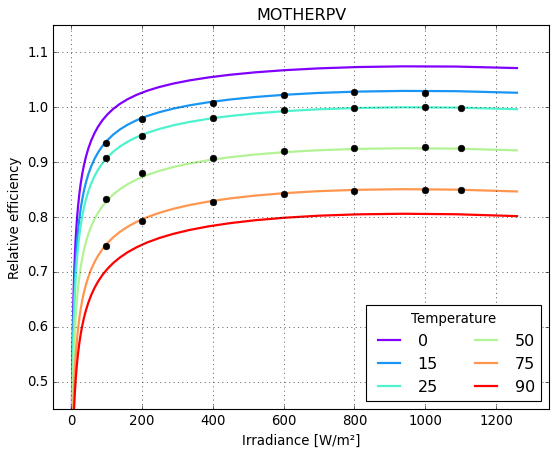

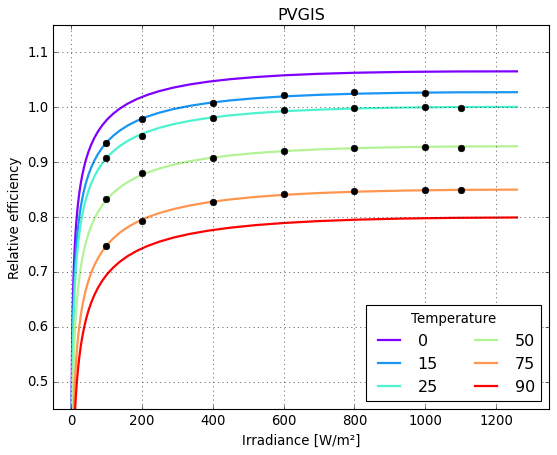

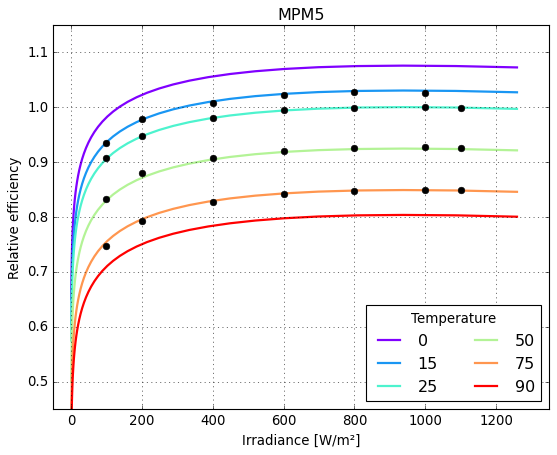

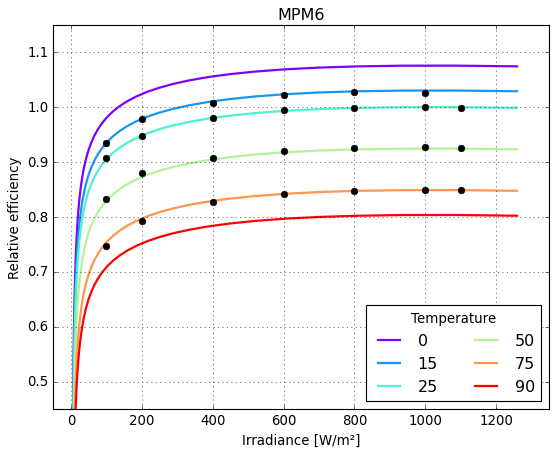

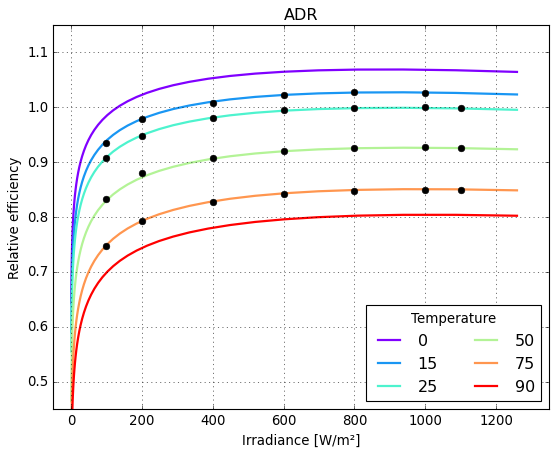

In [10]:
# now run and plot all the available models

models = [bilinear, heydenreich, motherpv, pvgis, mpm5, mpm6, adr]

for model in models:

    if model is bilinear:
        interpolator = fit_bilinear(**matrix)
        popt = [interpolator]
    else:
        popt, pcov = fit_efficiency_model(**matrix, model=model)
    plot_model(model, popt)
    plt.plot(grid, 'ko');    
    

In [11]:
# make a function to calculate rms error

def efficiency_model_rmse(irradiance, temperature, eta, model, p):

    from numpy import sqrt as root, mean, square

    eta_hat = model(irradiance, temperature, *p)

    return root(mean(square(eta_hat - eta)))

rmse = efficiency_model_rmse(matrix.irradiance,
                             matrix.temperature,
                             matrix.eta,
                             model,
                             popt)

print(TYPE, model.__name__.upper(), rmse)

Panasonic HIT ADR 0.0020281990091446417


In [12]:
# compare the models

for model in models:

    if model is bilinear:
        interpolator = fit_bilinear(**matrix)
        popt = [interpolator]
    else:
        popt, pcov = fit_efficiency_model(**matrix, model=model)

    rmse = efficiency_model_rmse(**matrix, model=model, p=popt)
    
    print('%20s, %-20s %.5f' % (TYPE, model.__name__.upper(), rmse))


       Panasonic HIT, BILINEAR             0.00000
       Panasonic HIT, HEYDENREICH          0.00605
       Panasonic HIT, MOTHERPV             0.00249
       Panasonic HIT, PVGIS                0.00158
       Panasonic HIT, MPM5                 0.00291
       Panasonic HIT, MPM6                 0.00279
       Panasonic HIT, ADR                  0.00203


In [13]:
# now run one of the harder tests: extrapolating to the low irradiance values

subset_fit = matrix.query('irradiance >  200')
subset_err = matrix.query('irradiance <= 200')

for model in models:

    if model is bilinear:
        interpolator = fit_bilinear(**subset_fit)
        popt = [interpolator]
    else:
        popt, pcov = fit_efficiency_model(**subset_fit, model=model)

    rmse = efficiency_model_rmse(**subset_err, model=model, p=popt)
    
    print('%20s, %-20s %.5f' % (TYPE, model.__name__.upper(), rmse))


       Panasonic HIT, BILINEAR             0.03950
       Panasonic HIT, HEYDENREICH          0.02965
       Panasonic HIT, MOTHERPV             0.15094
       Panasonic HIT, PVGIS                0.02889
       Panasonic HIT, MPM5                 0.00490
       Panasonic HIT, MPM6                 0.08156
       Panasonic HIT, ADR                  0.00401


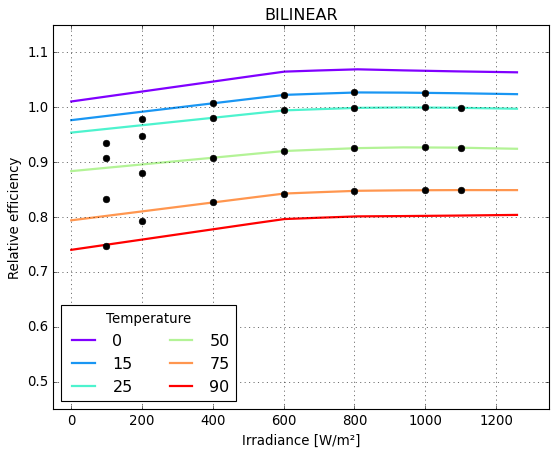

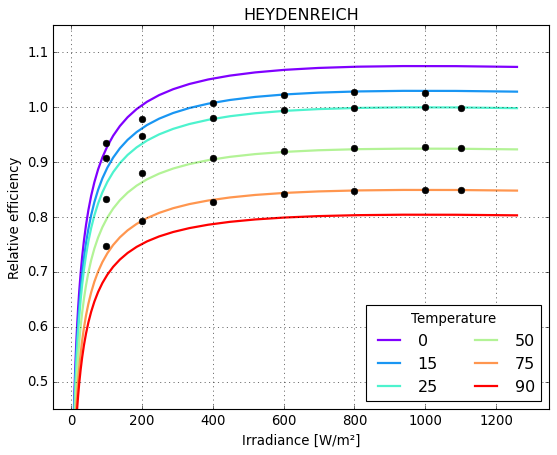

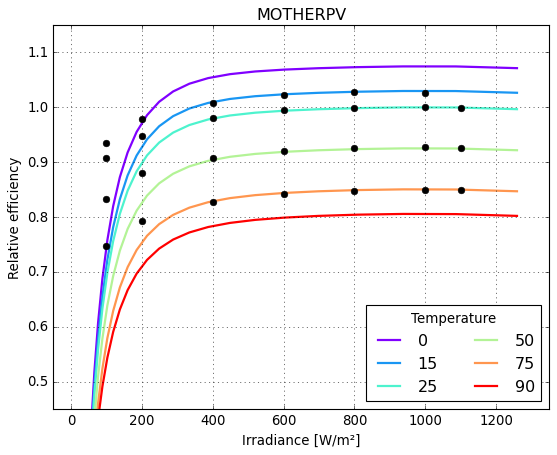

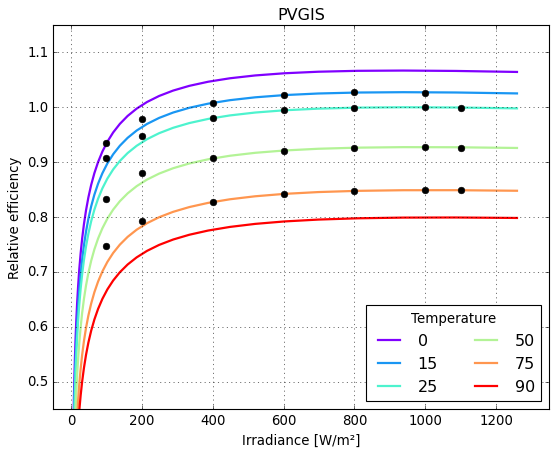

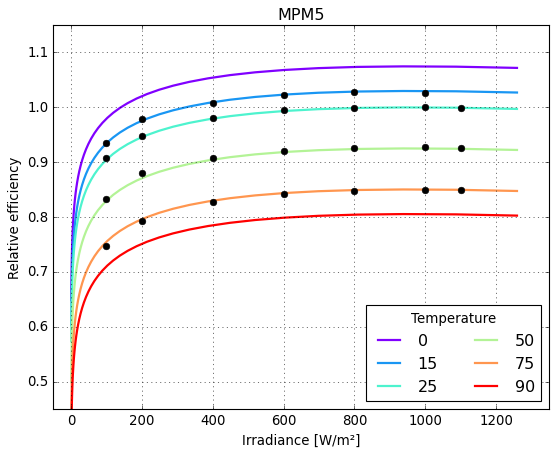

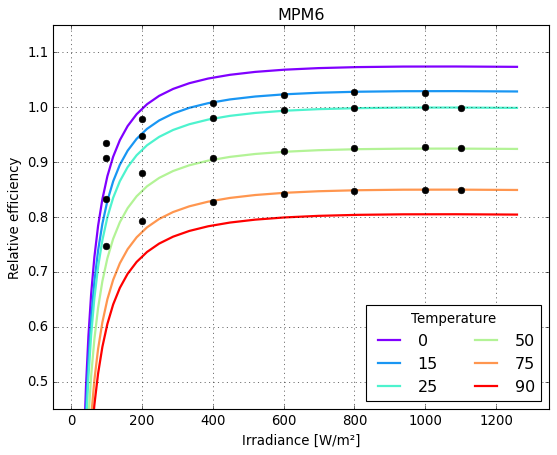

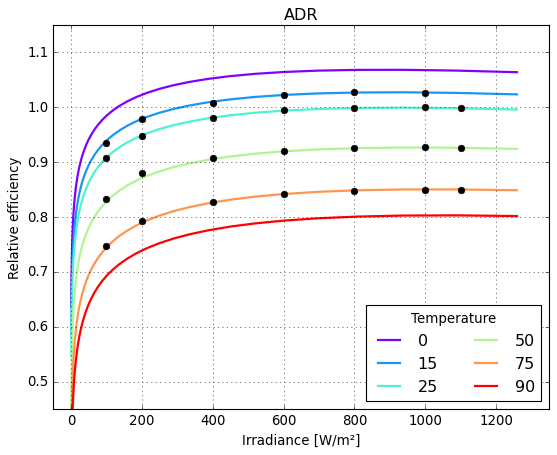

In [14]:
# the graphs make these differences more striking

for model in models:

    if model is bilinear:
        interpolator = fit_bilinear(**subset_fit)
        popt = [interpolator]
    else:
        popt, pcov = fit_efficiency_model(**subset_fit, model=model)
    plot_model(model, popt)
    plt.plot(grid, 'ko');    
    

In [15]:
# just one small detail missing:

# the last parameter of MPM6 should not be larger than zero
# so bounds need to be defined for all its parameters

MPM6_BOUNDS = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf,],
               [+np.inf, +np.inf, +np.inf, +np.inf,   0.0   ])

model = mpm6

popt, pcov = fit_efficiency_model(**subset_fit, model=model, bounds=MPM6_BOUNDS)
rmse = efficiency_model_rmse(**subset_err, model=model, p=popt)

print('%-20s %-20s RMSE = %.5f' % (TYPE, model.__name__.upper(), rmse))
print('popt =', popt)

Panasonic HIT        MPM6                 RMSE = 0.08156
popt = [ 1.03574972 -0.00299249 -0.0475798  -0.00717015 -0.02903406]


In [16]:
# in this case the bounds did not influence the result